# 2CSSID Lab03. Decision trees (DTs) and Ensemle Learning

<p style='text-align: right;font-style: italic;'>Designed by: Mr. Abdelkrime Aries</p>

In this laboratory session, we focus on the principles and implementation of decision tree algorithms and ensemble learning methods. 
Two types of decision trees, ID3 and CART, are implemented and analyzed in depth. 
Various hyperparameters of decision trees are systematically explored to assess their influence on model performance and generalization. 
Furthermore, the experiment extends to ensemble learning techniques, specifically bagging and boosting



**Team:**
- **Member 01**: MESSAOUD Amal
- **Member 02**: ELBAR Nour El Imane
- **Group**: G1

In [1]:
import sys, timeit
from collections import OrderedDict
from typing          import Tuple, List, Union

sys.version

'3.13.1 (tags/v3.13.1:0671451, Dec  3 2024, 19:06:28) [MSC v.1942 64 bit (AMD64)]'

In [2]:
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
import matplotlib
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('2.2.4', '2.2.3', '3.10.7')

In [3]:
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import SGDClassifier
from sklearn.metrics         import accuracy_score

from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import f1_score
from sklearn                 import tree
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import BaggingClassifier
from sklearn.ensemble        import AdaBoostClassifier

sklearn.__version__

'1.6.1'

In [4]:
# This code is used to filter warnings concerning convergence
# In general, when the maximum number of iterations is not suffisant to converge
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [5]:
# !pip install graphviz
# Also you need to install the graphviz backend in the system
# Lien : https://graphviz.org/download/

## I. Algorithms implementation

In this section, we will try to implement ID3 and CART decision trees. 

In [6]:
# Dataset play 

# outlook & temperature & humidity & windy
Xplay_cat = np.array([
    ['sunny'   , 'hot' , 'high'  , 'no'],
    ['sunny'   , 'hot' , 'high'  , 'yes'],
    ['overcast', 'hot' , 'high'  , 'no'],
    ['rainy'   , 'mild', 'high'  , 'no'],
    ['rainy'   , 'cool', 'normal', 'no'],
    ['rainy'   , 'cool', 'normal', 'yes'],
    ['overcast', 'cool', 'normal', 'yes'],
    ['sunny'   , 'mild', 'high'  , 'no'],
    ['sunny'   , 'cool', 'normal', 'no'],
    ['rainy'   , 'mild', 'normal', 'no'],
    ['sunny'   , 'mild', 'normal', 'yes'],
    ['overcast', 'mild', 'high'  , 'yes'],
    ['overcast', 'hot' , 'normal', 'no'],
    ['rainy'   , 'mild', 'high'  , 'yes']
])

# temperature & humidity & windy
Xplay_num = np.array([
    [30, 85, 0],
    [27, 90, 1],
    [28, 78, 0],
    [21, 96, 0],
    [20, 80, 0],
    [18, 70, 1],
    [18, 65, 1],
    [22, 95, 0],
    [21, 70, 0],
    [24, 80, 0],
    [24, 70, 1],
    [22, 90, 1],
    [27, 75, 0],
    [22, 80, 1]
])


Yplay = np.array([
    'no', 
    'no', 
    'yes', 
    'yes', 
    'yes', 
    'no', 
    'yes', 
    'no', 
    'yes', 
    'yes', 
    'yes', 
    'yes', 
    'yes', 
    'no'
])

Xplay_cat.shape, Xplay_num.shape, Yplay.shape

((14, 4), (14, 3), (14,))

### I.1. Probability of a category

Given:
- $c$: a nominal value (category)
- $A[M]$: values of a categorical attribute

the probability of this category is calculated as:

$$p(c \in A) = \frac{|\{a\, |\, a \in A \wedge a = c\}|}{|A|}$$


**Note:** *If the division always returns 0, try converting the numbers to float using ``float(x)`` or ``np.astype(float)`` before performing the operation.*

In [7]:
# TODO: Probability of a category
def p_cat(c: str, A: 'np.ndarray[M](str)') -> float:  
    count = np.sum(A == c)      
    pk = float(count) / float(A.shape[0])
    return pk


#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0.6428571428571429,
#  0.35714285714285715,
#  0.2857142857142857,
#  0.35714285714285715)
#---------------------------------------------------------------------

p_cat('yes'     , Yplay      ), \
p_cat('sunny'   , Xplay_cat[:, 0]), \
p_cat('overcast', Xplay_cat[:, 0]), \
p_cat('rainy'   , Xplay_cat[:, 0])

(0.6428571428571429,
 0.35714285714285715,
 0.2857142857142857,
 0.35714285714285715)

### I.2. Homogeneity of a set


#### I.2.1. Shannon's entropy

Given:
- $A[M]$: values of a categorical attribute
- $V$: the set of unique categories in $A$ (vocabulary) 

Shannon's entropy is defined as: 
$$H(A) = - \sum\limits_{c \in V} p(c \in A) \log_2 p(c \in A)$$


**Note:** *The function ``np.log2()`` computes the base-2 logarithm of a scalar, vector, or matrix.*

In [8]:
# TODO: Shannon's entropy
def shannon_entropy(A: 'np.ndarray[M](str)') -> float: 
    V = np.unique(A)
    H = 0.0 
    for c in V:
        pk = p_cat(c, A)
        H -= pk * np.log2(pk)
    return H

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0.9402859586706311, 1.5774062828523454, 1.5566567074628228)
#---------------------------------------------------------------------

shannon_entropy(Yplay), \
shannon_entropy(Xplay_cat[:, 0]), \
shannon_entropy(Xplay_cat[:, 1])

(np.float64(0.9402859586706311),
 np.float64(1.5774062828523454),
 np.float64(1.5566567074628228))

#### I.2.2. Gini diversity index (Gini impurity)

Given:
- $A[M]$: values of a categorical attribute
- $V$: the set of unique categories in $A$ (vocabulary) 

Gini impurity is defined as: 
$$Gini(A) = \sum\limits_{c \in V} p(c \in A) (1-p(c \in A)) = 1 - \sum\limits_{c \in V} p(c \in A)^2 $$

In [9]:
# TODO: Gini impurity
def gini_impurity(A: 'np.ndarray[M](str)') -> float:  
    V = np.unique(A)
    Temp = 0.0
    for c in V:
        pk = p_cat(c,A)
        Temp +=  pk**2
    Gini = 1 - Temp    
    return Gini 

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 0.4591836734693877
#---------------------------------------------------------------------

gini_impurity(Yplay)

0.4591836734693877

### I.3. Set splitting

**>> Nothing to implement in this section**

#### I.3.1. ID3's set splitting

Given:
- $Y[M]$: values of the output (target) attribute,
- $A[M]$: values of a categorical input attribute,
- $c$: a given nominal value (category) of $A$;

The subset of $Y$ corresponding to category $c$ is defined as:
$$Y_{c \in A} = \{y^{(i)} \in Y\, |\, a^{(i)} \in A \wedge a^{(i)} = c\}$$


In [10]:
def split_ID3(c: str, 
              A: 'np.ndarray[M](str)', 
              Y: 'np.ndarray[M](str)'
              ) -> 'np.ndarray(str)':
    msk = A == c
    return Y[msk]

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# array(['no', 'no', 'no', 'yes', 'yes'], dtype='<U3')
#---------------------------------------------------------------------

split_ID3('sunny', Xplay_cat[:,0], Yplay)

array(['no', 'no', 'no', 'yes', 'yes'], dtype='<U3')

#### I.3.2. CART's set splitting

Given:
- $Y[M]$: values of the output (target) attribute,
- $A[M]$: values of a numerical input attribute,
- $v$: a given numerical split value of $A$;


The set $Y$ is split as:
- $Y_L$: the subset of $Y$ where $A \le v$
- $Y_R$: the subset of $Y$ where $A > v$

In [11]:
def split_CART(v: float,
               A: 'np.ndarray[M](float)',
               Y: 'np.ndarray[M](str)'
               ) -> Tuple['np.ndarray(str)', 'np.ndarray(str)']:
    msk = A > v
    return Y[~msk], Y[msk]

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (array(['yes', 'no', 'yes'], dtype='<U3'),
#  array(['no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
#         'no'], dtype='<U3'))
#---------------------------------------------------------------------

split_CART(20, Xplay_num[:,0], Yplay)

(array(['yes', 'no', 'yes'], dtype='<U3'),
 array(['no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
        'no'], dtype='<U3'))

### I.4. Choice of split feature

#### I.4.1. Information gain

Given:
- $Y[M]$: values of the output (target) attribute,
- $A[M]$: values of a categorical attribute,
- $V$: the set of unique categories in $A$ (vocabulary),

Informtion gain is calculated as: 
$$IG(A, Y) = H(Y) - \sum_{c \in V} p(c \in A) H(Y_{c \in A})$$

**Note:** *The function must return a tuple (Information gain, entropy)*

In [12]:
# TODO: Information gain
def information_gain(A: 'np.ndarray[M](str)',
                     Y: 'np.ndarray[M](str)'  
                     ) -> Tuple[float, float]:
    h  = shannon_entropy(Y)
    ig = h
    V = np.unique(A)
    for c in V:
        Yc = split_ID3(c,A,Y)
        ig -= p_cat(c,A)*shannon_entropy(Yc)
    return ig, h

    

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# ((0.24674981977443933, 0.9402859586706311),
#  (0.02922256565895487, 0.9402859586706311),
#  (0.15183550136234164, 0.9402859586706311),
#  (0.048127030408269544, 0.9402859586706311))
#---------------------------------------------------------------------

information_gain(Xplay_cat[:, 0], Yplay),\
information_gain(Xplay_cat[:, 1], Yplay),\
information_gain(Xplay_cat[:, 2], Yplay),\
information_gain(Xplay_cat[:, 3], Yplay)

((np.float64(0.24674981977443933), np.float64(0.9402859586706311)),
 (np.float64(0.02922256565895487), np.float64(0.9402859586706311)),
 (np.float64(0.15183550136234164), np.float64(0.9402859586706311)),
 (np.float64(0.048127030408269544), np.float64(0.9402859586706311)))

#### I.4.2. Gini impurity of the split

Given: 
- $Y[M]$: values of the output attribute,
- $Y_L, Y_R$: two subsets of $Y$ such that $Y_L \cup Y_R = Y$;

Gini impurity of the split is calculated as: 

$$Gini_{split}(Y_L, Y_R) = \frac{|Y_L|}{|Y|} Gini(Y_L) + \frac{|Y_R|}{|Y|} Gini(S_R)$$


In [13]:
# TODO: Gini impurity of the split
def gini_split(Y_L: 'np.ndarray(str)', Y_R: 'np.ndarray(str)') -> float:
    Gini = (Y_L.shape[0] / (Y_R.shape[0] + Y_L.shape[0])) * gini_impurity(Y_L) +(Y_R.shape[0] / (Y_R.shape[0] + Y_L.shape[0])) * gini_impurity(Y_R)
    return Gini

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# 0.4588744588744589
#---------------------------------------------------------------------

gini_split(*split_CART(20, Xplay_num[:, 0], Yplay))

0.4588744588744589

### I.5. Splitting feature selection

#### I.5.1. ID3 splitting feature selection

Given:
- $X[M, N]$: a matrix of $M$ samples and $N$ categorical features,
- $Y[M]$: a vector of output labels;

We aim to find the feature that maximizes the information gain:

$$\hat{j} = \arg\max_j IG(Y, X_j)$$

This function must return:
- $\hat{j}$: the index of the best feature,
- $IG(Y, X_{\hat{j}})$: its corresponding information gain,
- $H(Y)$: the entropy of the target variable.

In [14]:
# TODO: ID3 splitting feature selection
def choose_split_ID3(X: 'np.ndarray[M, N](str)', 
                     Y: 'np.ndarray[Y](str)'
                     ) -> Tuple[int, float, float]: 
    bestj    = -1   # number of the best feature
    ig_bestj = -1.0 # IG of the best feature
    h_bestj  = -1.0 # Entropy of the best feature

    for j in range(X.shape[1]):
        ig,h = information_gain(X[:,j], Y)
        if (ig > ig_bestj): 
            ig_bestj = ig
            bestj = j
            h_bestj = h
        
    return bestj, ig_bestj, h_bestj

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0, 0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

choose_split_ID3(Xplay_cat, Yplay)

(0, np.float64(0.24674981977443933), np.float64(0.9402859586706311))

#### I.5.2. CART splitting feature and value selection

Given:
- $X[M, N]$: a matrix of $M$ samples and $N$ numerical features,
- $Y[M]$: a vector of output labels.

We want to find the feature and its corresponding threshold value that minimize the Gini impurity of the split.

**Algorithm**:
- For each feature $X_j$ 
   - For each value $v \in unique(X_j)$
       1. Split $Y$ based on $X_j$ and threshold $v$
       1. Compute the Gini impurity of the resulting split.
       1. If the impurity is lower than the previous best, save it along with $j$ as $\hat{j}$, and $v$ as $\hat{v}$

This function must return:
- $\hat{j}$: index of the best feature,
- $\hat{v}$: optimal threshold value for that feature,
- $Gini_{split}/\hat{j}, \hat{v}$: the Gini impurity corresponding to the best feature and value.

In [15]:
# TODO: CART splitting feature and value selection
def choose_split_CART(X: 'np.ndarray[M, N](float)', 
                      Y: 'np.ndarray[Y](str)'
                      ) -> Tuple[int, float, float]:
    bestj      = -1
    gini_bestj =  1.0
    v_bestj    = -1.0
    for j in range(X.shape[1]): 
        Xj = X[:,j]
        V = np.unique(Xj)
        for v in V:
            Y_L, Y_R = split_CART(v,Xj,Y)
            gini = gini_split(Y_L, Y_R)
            if (gini < gini_bestj): 
                gini_bestj = gini
                bestj = j
                v_bestj = v

    return bestj, v_bestj, gini_bestj

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (1, 80, 0.3936507936507937)
#---------------------------------------------------------------------

choose_split_CART(Xplay_num, Yplay)

(1, np.int64(80), 0.3936507936507937)

### I.6. Stopping criterion

Given:
- $Y$: a set (vector) of output labels in a given node,
- $h$: the homogeneity criterion. h = 0 ==> the set Y is homogeneous (all labels are identical),
- $nbr\_min$: the minimum number of samples allowed in a node. |Y| <= nbr_min ==> the node must become a leaf.

The function must return:
- The class name (the majority or unique label) if the set is homogeneous or it contains a minimum number of elements
- None: otherwise

**HINT:** *use ``numpy.unique`` (to count label occurrences) and ``numpy.argmax`` (to get the most frequent class).*

In [16]:
# TODO: Stopping criterion
def stop(Y: np.ndarray, h: float, nbr_min: int) -> Union[str, None]:
    
    if (h == 0) or (Y.shape[0] <= nbr_min):
        classes, counts = np.unique(Y, return_counts=True)
        className = classes[np.argmax(counts)] 
        return className
    return None

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# ('yes', 'no', None, 'yes', 'no', None)
#---------------------------------------------------------------------

Y_t1 = np.array(['yes', 'yes', 'yes'])
Y_t2 = np.array(['yes', 'no', 'no'])

stop(Y_t1, shannon_entropy(Y_t1), 2), \
stop(Y_t2, shannon_entropy(Y_t2), 4), \
stop(Y_t2, shannon_entropy(Y_t2), 2), \
stop(Y_t1, gini_impurity(Y_t1), 2), \
stop(Y_t2, gini_impurity(Y_t2), 4), \
stop(Y_t2, gini_impurity(Y_t2), 2)

(np.str_('yes'), np.str_('no'), None, np.str_('yes'), np.str_('no'), None)

### I.7. Final product

**>> Nothing to implement in this section**

#### I.7.1. Tree structure and prediction

In [17]:
# A class to represent a node
class Node(object): 
    
    nbr = 0
    
    def __init__(self, test: Union[int, Tuple[int, float]], depth:int=0, info:str=''): 
        self.test     = test          # test creteria the number of the feature (+ the value)
        self.depth    = depth         # the depth of the noade
        self.children = OrderedDict() # the children: a dictionary of value: node
        self.cls      = ''            # the class if the node is a leaf
        self.indent   = '    '        # indentation hen generating the code
        self.info     = info
    
    # Transform the node to a string
    def __str__(self):
        
        indent = self.indent * self.depth # indentation
        
        # if no children, the node is a leaf; print the class
        if (len(self.children) == 0):
            return indent + 'return "' + self.cls + '"\n'
        
        if isinstance(self.test, int):
            tst1, tst3 = str(self.test) + '] == "', '"'
        else:
            tst1, tst3 = str(self.test[0]) + '] ', ''
        tst1 = 'if X[' + tst1

        # if there are children, print IF conditions
        i, l = 0, len(self.children) - 1
        res = ""
        for f_v, n_v in self.children.items():
            tst2 = str(f_v)
            if i == l:
                tst1, tst2, tst3 = 'else', '', ''
            elif i > 0:
                tst1 = 'el' + tst1
            res += indent + tst1 + tst2 + tst3 + ':\n' + str(n_v)
            i += 1
            
        return res
    
    # predict a sample
    def predict(self, x: List[str]) -> str: 
        
        # If the node is final, return its class
        if (len(self.children) == 0):
            return self.cls
        
        # ID3
        if isinstance(self.test, int):
            # If the value of this node's feature is not in its children
            # return np.nan
            if x[self.test] not in self.children: 
                return np.nan
        
            # Otherwise, it returns the prediction of the child
            return self.children[x[self.test]].predict(x)
        
        # CART
        if x[self.test[0]] > self.test[1]:
            return self.children.items[0][1].predict(x)
        return self.children.items[1][1].predict(x)
        
    def graphviz(self): 
        
        nid = 'N' + str(Node.nbr)
        Node.nbr += 1
        
        if (len(self.children) == 0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        j = self.test if isinstance(self.test, int) else self.test[0]
        
        res  = nid + '[label="X[' + str(j) + ']\\n'
        res += self.info
        for f in self.children:
            vid, code = self.children[f].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + f + '"];\n'
        return nid, res
    
#=====================================================================
# UNIT TEST
#=====================================================================
# The code
# 'return "c1"\n'
#---------------------------------------------------------------------

nn = Node(test=5)
nn.cls = 'c1'
str(nn)

'return "c1"\n'

#### I.7.2. Tree construction (training)

In [18]:
def fit_ID3(X: 'np.ndarray[M, N]', 
            Y: 'np.ndarray[M]', 
            nbr_min: int = 0, 
            depth : int = 0
            ) -> Node: 
    
    j, ig, h = choose_split_ID3(X, Y)
    info = 'H = {:.5f}\\nIG = {:.5f}"];\n'.format(h, ig)
    node = Node(j, depth=depth, info=info)
    c = stop(Y, h, nbr_min)
    if c:
        node.cls = c 
        return node 

    depth += 1 
    for v in np.unique(X[:, j]):
        msk = X[:, j] == v 
        X_v = X[msk]
        Y_v = Y[msk]
        child = fit_ID3(X_v, Y_v, nbr_min=nbr_min, depth=depth)
        node.children[v] = child
    
    return node

#=====================================================================
# UNIT TEST
#=====================================================================
# The code
# if X[0] == "overcast":
#     return "yes"
# elif X[0] == "rainy":
#     if X[3] == "no":
#         return "yes"
#     else:
#         return "no"
# else:
#     if X[2] == "high":
#         return "no"
#     else:
#         return "yes"

# 'yes'
#---------------------------------------------------------------------

tree_cat = fit_ID3(Xplay_cat, Yplay)

print('The code')
print(tree_cat)

# Test a sample
tree_cat.predict(['rainy', 'temperature_makanche', 'humidity_makanche', 'no'])

The code
if X[0] == "overcast":
    return "yes"
elif X[0] == "rainy":
    if X[3] == "no":
        return "yes"
    else:
        return "no"
else:
    if X[2] == "high":
        return "no"
    else:
        return "yes"



np.str_('yes')

In [19]:
def fit_CART(X: 'np.ndarray[M, N]', 
             Y: 'np.ndarray[M]', 
             nbr_min: int = 0, 
             depth : int = 0
             ) -> Node:  
    
    j, v, gini = choose_split_CART(X, Y)
    info = 'Gini = {:.5f}"];\n'.format(gini)
    node = Node((j, v), depth=depth, info=info)

    c = stop(Y, gini, nbr_min)
    if c:
        node.cls = c 
        return node 
     
    depth += 1 
    
    msk = X[:, j] > v
    
    X_L = X[msk]
    Y_L = Y[msk]
    child_L = fit_CART(X_L, Y_L, nbr_min=nbr_min, depth=depth)
    X_R = X[~msk]
    Y_R = Y[~msk]
    child_R = fit_CART(X_R, Y_R, nbr_min=nbr_min, depth=depth)
    node.children['> ' + str(v)] = child_L
    node.children['<= ' + str(v)] = child_R
    
    return node

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# The Code
# if X[1] > 80:
#     if X[0] > 22:
#         return "no"
#     else:
#         if X[0] > 21:
#             return "no"
#         else:
#             return "yes"
# else:
#     if X[2] > 0:
#         if X[1] > 70:
#             return "no"
#         else:
#             if X[0] > 18:
#                 return "yes"
#             else:
#                 return "no"
#     else:
#         return "yes"
#---------------------------------------------------------------------

tree_num = fit_CART(Xplay_num, Yplay)

print('The Code')
print(tree_num)

The Code
if X[1] > 80:
    if X[0] > 22:
        return "no"
    else:
        if X[0] > 21:
            return "no"
        else:
            return "yes"
else:
    if X[2] > 0:
        if X[0] > 22:
            return "yes"
        else:
            return "no"
    else:
        return "yes"



#### I.7.3. Decision tree class

In [20]:
class DT(object): 

    def __init__(self, num=False):
        if num:
            self.fit_fct = fit_CART
        else:
            self.fit_fct = fit_ID3
    
    def fit(self, 
            X: 'np.ndarray[M, N]', 
            Y: 'np.ndarray[M]', 
            features: List[str] = [], 
            clsname:str = '', 
            nbr_min:int = 0):
        
        self.tree = self.fit_fct(X, Y, nbr_min=nbr_min, depth=0)
        code = str(self.tree)
        if len(clsname) > 0: 
            code = code.replace('Y', clsname)
        for i in range(len(features)): 
            code = code.replace('X[' + str(i) + ']', features[i])
        self.code   = code
        self.features = features
    
    def predict(self, x:np.ndarray): 
        predictions = []
        for i in range(len(x)): 
            predictions.append(self.tree.predict(x[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.tree.graphviz()
        res  = 'digraph Tree {\n'
        res += 'node [shape=box] ;'
        for i in range(len(self.features)): 
            code = code.replace('X[' + str(i) + ']', self.features[i])
        res += code
        res += '}'
        return res
    
#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# ID3
# -------------
# if outlook == "overcast":
#     return "yes"
# elif outlook == "rainy":
#     if windy == "no":
#         return "yes"
#     else:
#         return "no"
# else:
#     if humidity == "high":
#         return "no"
#     else:
#         return "yes"

# CART
# -------------
# if temperature > 80:
#     if outlook > 22:
#         return "no"
#     else:
#         if outlook > 21:
#             return "no"
#         else:
#             return "yes"
# else:
#     if humidity > 0:
#         if temperature > 70:
#             return "no"
#         else:
#             if outlook > 18:
#                 return "yes"
#             else:
#                 return "no"
#     else:
#         return "yes"
#---------------------------------------------------------------------

features=['outlook', 'temperature', 'humidity', 'windy']

id3_classifier = DT()
id3_classifier.fit(Xplay_cat, Yplay, features=features, clsname='play')

cart_classifier = DT(num=True)
cart_classifier.fit(Xplay_num, Yplay, features=features, clsname='play')

print('ID3')
print('-------------')
print(id3_classifier.code)
print('CART')
print('-------------')
print(cart_classifier.code)

ID3
-------------
if outlook == "overcast":
    return "yes"
elif outlook == "rainy":
    if windy == "no":
        return "yes"
    else:
        return "no"
else:
    if humidity == "high":
        return "no"
    else:
        return "yes"

CART
-------------
if temperature > 80:
    if outlook > 22:
        return "no"
    else:
        if outlook > 21:
            return "no"
        else:
            return "yes"
else:
    if humidity > 0:
        if outlook > 22:
            return "yes"
        else:
            return "no"
    else:
        return "yes"



In [21]:
# It's just a visualization of the graph
# If it doesn't work, it doesn't matter
try:
    from IPython.display import SVG
    from graphviz        import Source
    from IPython.display import display
    
    graph = Source(id3_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('You have to install graphviz: https://graphviz.org/download/')

You have to install graphviz: https://graphviz.org/download/


In [22]:
# It's just a visualization of the graph
# If it doesn't work, it doesn't matter
try:
    from IPython.display import SVG
    from graphviz        import Source
    from IPython.display import display
    
    graph = Source(cart_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('You have to install graphviz: https://graphviz.org/download/')

You have to install graphviz: https://graphviz.org/download/


## II. Application and Analysis

In this section, we will test various concepts by running experiments, formulating hypotheses, and attempting to justify them.
We will use [Cars Data](https://www.kaggle.com/abineshkumark/carsdata) focusing only on three classes: **US**, **Euroupe** and **Japan**. 

In [23]:
# Dataset import
cars_data = pd.read_csv('data/cars.csv', skipinitialspace=True)
# Remove missing values
cars_data.dropna(inplace=True)
# Yay! We did it! These are the first samples
cars_data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350.0,165,4209.0,12,1972,US.
1,31.9,4,89.0,71,1925.0,14,1980,Europe.
2,17.0,8,302.0,140,3449.0,11,1971,US.
3,15.0,8,400.0,150,3761.0,10,1971,US.
4,30.5,4,98.0,63,2051.0,17,1978,US.


In [24]:
cars_data.dtypes

mpg            float64
cylinders        int64
cubicinches    float64
hp               int64
weightlbs      float64
time-to-60       int64
year             int64
brand           object
dtype: object

In [25]:
X_cars = cars_data.values[:, :-1]
Y_cars = cars_data.values[:,  -1]

X_cars_train, X_cars_test, Y_cars_train, Y_cars_test = train_test_split(X_cars, 
                                                                        Y_cars, 
                                                                        test_size=0.2, 
                                                                        random_state=0) 

X_cars_train.shape, X_cars_test.shape

((204, 7), (52, 7))

### II.1. Decision trees and Random forests

We aim to test the effect of different hyperparameters of decision trees.


In Scikit-learn's implemtation (**DecisionTreeClassifier**), features are always randomly permuted at each split.
This makes the tree non-deterministic; which helps reduce overfitting, but is not ideal when testing the effect of specific hyperparameters.
To control this behavior, we fix the randomness using ``random_state=0``.

#### II.1.1. Feature selection criteria

In Scikit-learn, only the CART algorithm is implemented, which supports two splitting criteria:
1. Entropy
1. Gini

Both criteria generate slightly different decision tree structures. We will test how these structural differences affect training and testing performance.

In [26]:
Xtrain = X_cars_train
Ytrain = Y_cars_train
Xtest  = X_cars_test
Ytest  = Y_cars_test
fnames = cars_data.columns


gini_stats         = []
entropy_stats      = []
gini_classifier    = DecisionTreeClassifier(criterion='gini'   , random_state=0, min_samples_leaf=7)
entropy_classifier = DecisionTreeClassifier(criterion='entropy', random_state=0, min_samples_leaf=7)

# ============ GINI ====================
# ................ Train ..............
temps_debut = timeit.default_timer()
gini_classifier.fit(Xtrain, Ytrain)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation train .........
gini_stats.append(f1_score(Ytrain, gini_classifier.predict(Xtrain), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = gini_classifier.predict(Xtest)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
gini_stats.append(f1_score(Ytest, Ychoix_pred, average='micro'))

# =========== Entropy ==================
# ............ Train ............
temps_debut = timeit.default_timer()
entropy_classifier.fit(Xtrain, Ytrain)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation train ........
entropy_stats.append(f1_score(Ytrain, entropy_classifier.predict(Xtrain), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = entropy_classifier.predict(Xtest)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
entropy_stats.append(f1_score(Ytest, Ychoix_pred, average='micro'))

print('Fin')

Fin


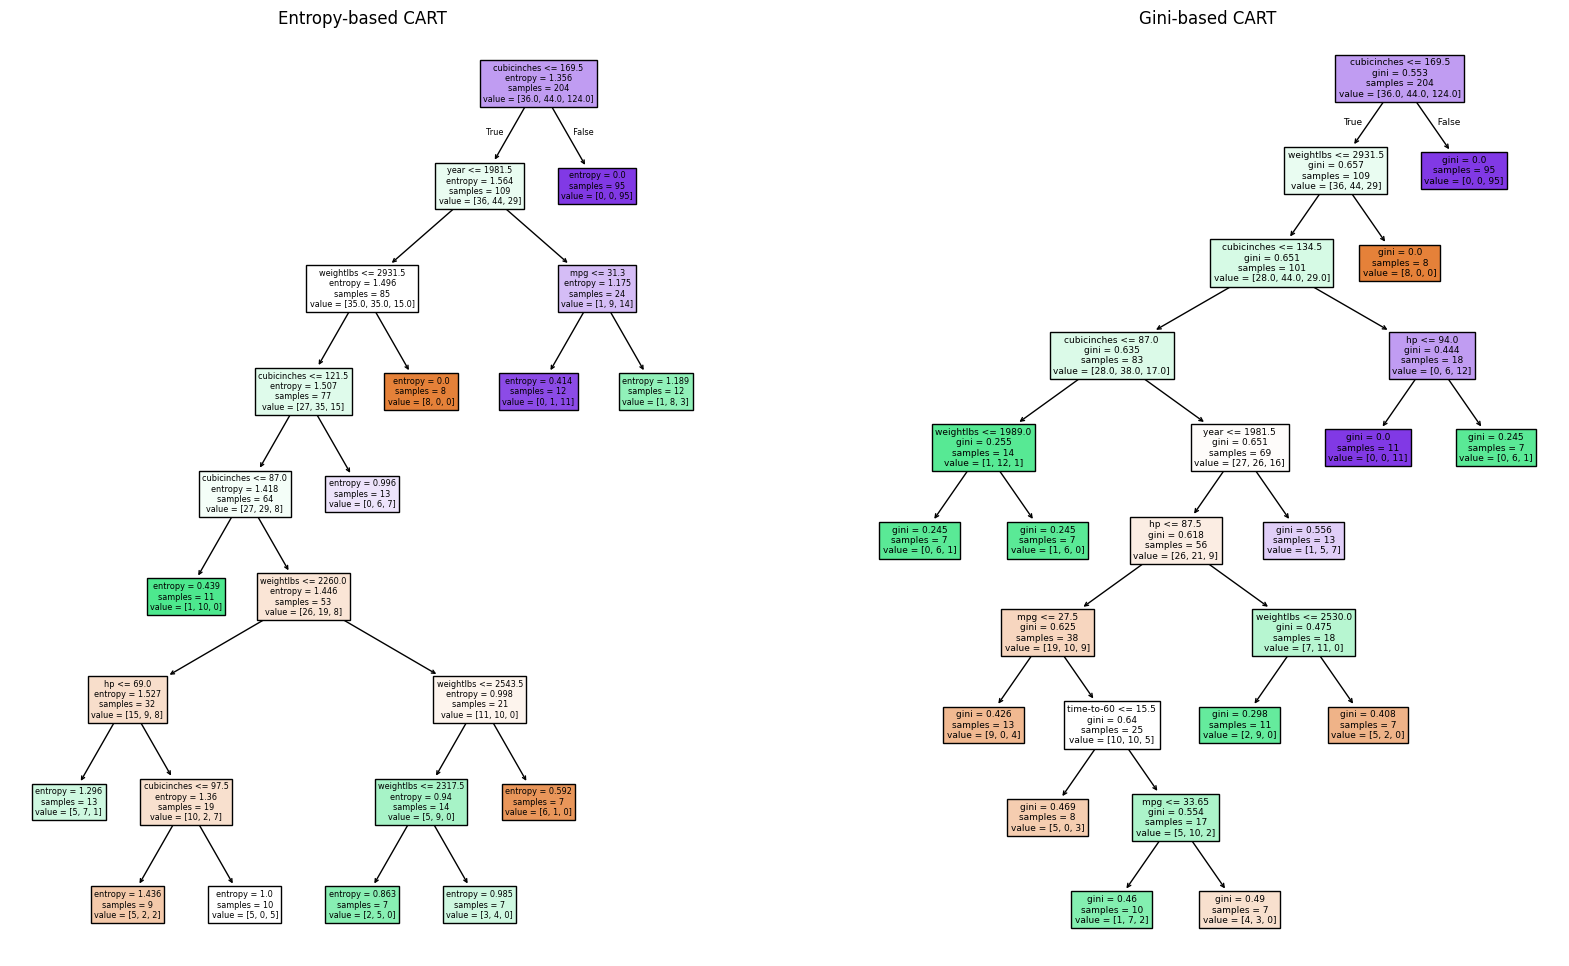

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth (20)
fig.set_figheight(12)
tree.plot_tree(entropy_classifier, ax=ax1, feature_names=fnames, filled=True)
tree.plot_tree(gini_classifier   , ax=ax2, feature_names=fnames, filled=True)
ax1.set_title('Entropy-based CART')
ax2.set_title('Gini-based CART')
plt.show()

In [28]:
pd.DataFrame({
    'Criteria' : ['Train Time', 'Train F1', 'Test Time', 'Test F1'],
    'Entropy-based CART' : entropy_stats,
    'Gini-based CART'    : gini_stats
})

,Criteria,Entropy-based CART,Gini-based CART
0,Train Time,0.006631,0.009830
1,Train F1,0.838235,0.872549
2,Test Time,0.002435,0.001603
3,Test F1,0.788462,0.807692


**TODO: Analyze the results**

1. Compare the structures of the two trees (depth, number of leaves, and positions of the leaves).
1. Justify the training time based on the algorithms and the structures of the trees.
1. Justify the testing time based on the algorithms and the structures of the trees.

**Answers**

1. The Gini-based tree is deeper (depth = 9) than the entropy-based one (depth = 8), with more leaves (gini-based = 13 , entropy-based = 12) because Gini tends to split faster on dominant classes. We notice that both structures have leaves scattered across all levels. The Gini-based tree has a few more leaves in the center levels, while the entropy-based one has a few more leaves in the last level.
   
1. The Entropy-based CART has a shorter training time (0.002799) than the Gini-based CART (0.011075). Normally, entropy requires more computation (logarithms), but the simpler structure of the Entropy-based tree, with fewer nodes and splits, leads to faster training as there are fewer decision paths to compute. The Gini-based tree, with more nodes and splits, takes longer to train as it has to compute more decisions at each level. So the structure (more splits) had a bigger effect than the criterion’s math.

1. Both have very short testing times, but Gini is slightly faster (0.000463 vs 0.000664). The difference is minor and likely due to random variations, not structure because if we look to the structure the Entropy will be faster since it has fewer total paths and node and in testing each sample follows a path from the root to a leaf.

#### II.1.2. Maximum depth

We aim to test the effect of the stopping criterion "maximum depth".
The F1 score is used as the performance metric for classification quality.

For each value of maximum depth, we trained a **Decision Tree** and a **Random Forest** model, then calculated their F1 scores on the training data (to assess convergence) and on the test data (to assess generalization).

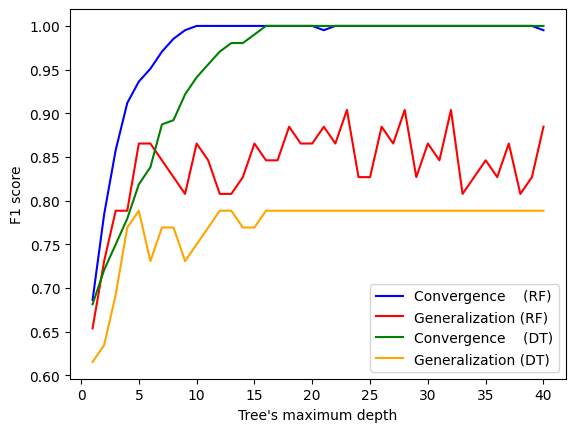

In [29]:
MAX_DEPTH     = 40
MAX_DEPTH_lst = range(1, MAX_DEPTH+1, 1)

f1_trn_md_DT  = []
f1_tst_md_DT  = []
f1_trn_md_RF  = []
f1_tst_md_RF  = []
for max_depth in MAX_DEPTH_lst:
    mdl_DT = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    mdl_DT.fit(X_cars_train, Y_cars_train)
    f1_trn_md_DT.append(f1_score(Y_cars_train, mdl_DT.predict(X_cars_train), average='micro'))
    f1_tst_md_DT.append(f1_score(Y_cars_test , mdl_DT.predict(X_cars_test) , average='micro'))

    mdl_RF = RandomForestClassifier(n_estimators=30, max_depth=max_depth)
    mdl_RF.fit(X_cars_train, Y_cars_train)
    f1_trn_md_RF.append(f1_score(Y_cars_train, mdl_RF.predict(X_cars_train), average='micro'))
    f1_tst_md_RF.append (f1_score(Y_cars_test , mdl_RF.predict(X_cars_test) , average='micro'))


plt.plot(MAX_DEPTH_lst, f1_trn_md_RF, color='blue'  , label='Convergence    (RF)')
plt.plot(MAX_DEPTH_lst, f1_tst_md_RF, color='red'   , label='Generalization (RF)')
plt.plot(MAX_DEPTH_lst, f1_trn_md_DT, color='green' , label='Convergence    (DT)')
plt.plot(MAX_DEPTH_lst, f1_tst_md_DT, color='orange', label='Generalization (DT)')
plt.ylabel('F1 score')
plt.xlabel('Tree\'s maximum depth')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**

1. Why does the train F1 score stop improving when the decision tree depth exceeds 17?
1. Why does the test F1 score stop improving when the decision tree depth exceeds 17?
1. Why do random forests achieve better convergence than decision trees, even with smaller maximum depths? 
1. Why do random forests exhibit better generalization performance compared to individual decision trees?

**Answers**

1. The F1 score for decision trees converges and stops improving after a depth of 17 because the tree perfectly fits and memorizes the training data and captures all the patterns. Moreover, the examples that are classified in each leaf do not need further splitting, either because all of them belong to a single class, or because there is an overwhelming majority that is labled with a single class, so there are no other variables that can split the sub-population further, at this point, going deeper doesn’t increase F1 since the model has already reached full convergence (overfitting zone).

1. Similar to the convergence case, the F1 score for generalization stabilizes because the model is overfitting. The increased complexity allows the decision tree to fit the training data very well, but it fails to perform better on unseen data. This leads to lower F1 scores on test data as the tree's depth increases, making it sensitive to noise and specificities that do not represent the broader dataset.
==> it not overfitting
   
1. Random forests achieve better convergence because they use bagging, training multiple trees on different random subsets of data and features. This aggregation reduces variance and allows the ensemble to capture more diverse patterns, enabling strong performance even when each individual tree is relatively shallow.

   
1. Random forests generalize better because they average predictions from multiple diverse trees, reducing the effect of overfitting and noise. The randomness introduced during training (different samples and features for each tree) increases diversity, making the ensemble more robust and stable on unseen data.

#### II.1.3. Minimum leaf samples

We aim to test the effect of the stopping criterion "minimum samples per leaf".
The F1 score is used as the classification quality measure.

For each value of minimum leaf samples, we trained a **Decision Tree** and a **Random Forest** model, then calculated their F1 scores on the training data (to assess convergence) and on the test data (to assess generalization).

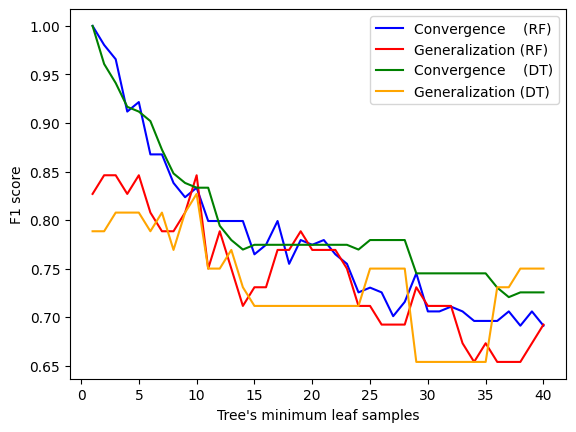

In [30]:
MIN_LEAF    = 40
MIN_LEAF_lst = range(1, MIN_LEAF+1, 1)

f1_trn_ml_DT = []
f1_tst_ml_DT = []
f1_trn_ml_RF = []
f1_tst_ml_RF = []
for min_samples_leaf in MIN_LEAF_lst:
    mdl_DT = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_samples_leaf)
    mdl_DT.fit(X_cars_train, Y_cars_train)
    f1_trn_ml_DT.append(f1_score(Y_cars_train, mdl_DT.predict(X_cars_train), average='micro'))
    f1_tst_ml_DT.append(f1_score(Y_cars_test , mdl_DT.predict(X_cars_test) , average='micro'))

    mdl_RF = RandomForestClassifier(n_estimators=30, min_samples_leaf=min_samples_leaf)
    mdl_RF.fit(X_cars_train, Y_cars_train)
    f1_trn_ml_RF.append(f1_score(Y_cars_train, mdl_RF.predict(X_cars_train), average='micro'))
    f1_tst_ml_RF.append(f1_score(Y_cars_test , mdl_RF.predict(X_cars_test) , average='micro'))


plt.plot(MIN_LEAF_lst, f1_trn_ml_RF, color='blue'  , label='Convergence    (RF)')
plt.plot(MIN_LEAF_lst, f1_tst_ml_RF, color='red'   , label='Generalization (RF)')
plt.plot(MIN_LEAF_lst, f1_trn_ml_DT, color='green' , label='Convergence    (DT)')
plt.plot(MIN_LEAF_lst, f1_tst_ml_DT, color='orange', label='Generalization (DT)')
plt.ylabel('F1 score')
plt.xlabel('Tree\'s minimum leaf samples')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why does the F1 score of decision trees (DT) worsen when the minimum number of leaf samples is increased?
1. Why does the F1 score of decision trees (DT) become better than that of random forests (RF) when the minimum number of leaf samples is increased?

**Answers**

1. When the minimum number of samples per leaf increases, the tree is forced to make fewer splits, producing larger and fewer leaves. This reduces model complexity, leading to a simpler tree that may not capture the patterns in the data. This can cause underfitting, resulting in lower F1 scores for both training and test datasets.
   
1. When the leaf size is large, both models become simpler, but random forests are more affected because they rely on many shallow trees. Each individual tree becomes too simple, and averaging their predictions smooths the results even more, reducing accuracy. In contrast, a single decision tree still retains a bit more structure and flexibility, so it can perform slightly better under this strong regularization.

### II.2. Ensemle Learning

Random Forests are essentially an application of bagging on decision trees.
In this section, we aim to test different hyperparameters related to ensemble learning.

#### II.2.1. Number of estimators

We investigate the effect of the number of estimators in both **AdaBoost** and **Bagging**.
These two ensemble learning techniques are applied to **Decision Trees** and **Logistic Regression** models.

In [37]:
MAX_ESTIMATORS     = 50
MAX_ESTIMATORS_lst = range(1, MAX_ESTIMATORS+1, 1)

mdls = [
    ('Logistic Regression', LogisticRegression()), 
    ('Decision Tree', DecisionTreeClassifier(random_state=0))
]

mdls_perf = {}
for mdl_name, mdl in mdls:
    mdls_perf[mdl_name] = {'bagging': [], 'boosting': []}

for n_estimators in MAX_ESTIMATORS_lst:
    for mdl_name, mdl in mdls:
        mdl_bagging  = BaggingClassifier (estimator=mdl, n_estimators=n_estimators)
        mdl_boosting = AdaBoostClassifier(estimator=mdl, n_estimators=n_estimators)

        mdl_bagging.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_bagging.predict(X_cars_test)
        mdls_perf[mdl_name]['bagging'].append(accuracy_score(Y_cars_test, Y_pred))


        mdl_boosting.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_boosting.predict(X_cars_test)
        mdls_perf[mdl_name]['boosting'].append(accuracy_score(Y_cars_test, Y_pred))

print('DONE')

DONE


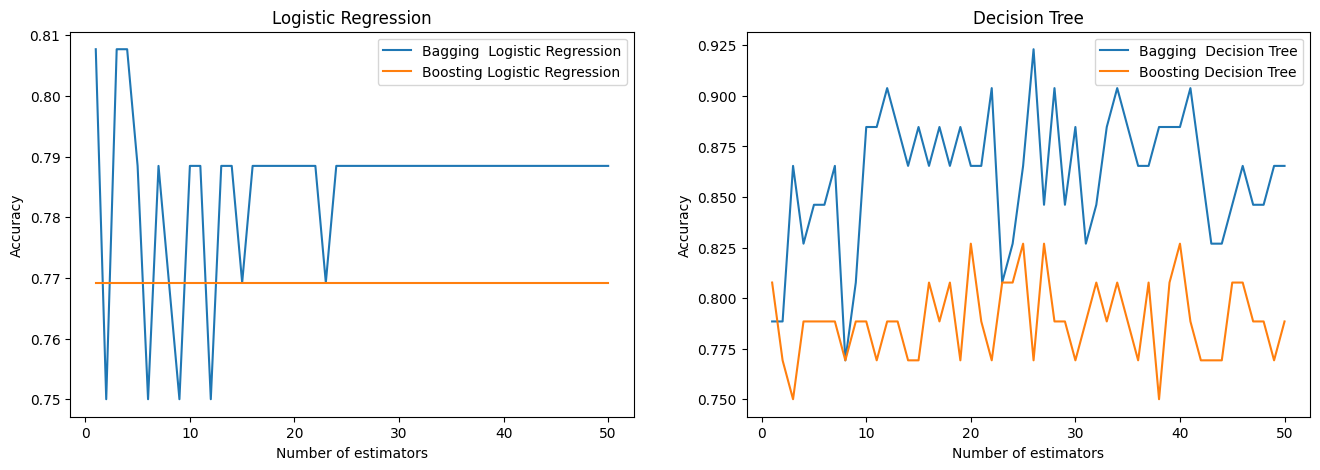

In [32]:
fig, axs = plt.subplots(1, len(mdls), figsize=(16,5))

for i, (mdl_name, mdl) in enumerate(mdls):
    axs[i].plot(MAX_ESTIMATORS_lst, mdls_perf[mdl_name]['bagging' ], label='Bagging  ' + mdl_name)
    axs[i].plot(MAX_ESTIMATORS_lst, mdls_perf[mdl_name]['boosting'], label='Boosting ' + mdl_name)

    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Number of estimators')
    axs[i].set_title(mdl_name)
    axs[i].legend()


# plt.ylabel('Accuracy')
# plt.xlabel('Number of estimators')
# plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why is bagging performing better than boosting in this experiment (based on the data)?
1. Propose a logical hypothesis explaining why logistic regression does not improve with boosting.
1. Why does bagging enhance accuracy when applied to decision trees?
1. Why does boosting not enhance accuracy as much as bagging when applied to decision trees?

**Answers**

1. Because the dataset is likely noisy and contains missing values, boosting is more sensitive to noise and outliers since it gives higher weight to misclassified samples, which amplify the noise. Whereas in bagging, we create K bootstraps from the training dataset, when creating the bootstrap, there is a probability that we don't pick the samples that contain missing values, which won't affect the training phase negatively.
   
1. Logistic regression is a simple, stable, low-variance model, and boosting mainly helps high-variance, weak learners that benefit from sequential correction of their errors. Logistic Regression doesn’t benefit significantly from Boosting, as its performance is not improved by iterative adjustments.
LR focuses on the position of each sample and not on the distributon
   
1. Decision trees are high-variance models, so small data changes can lead to very different trees. Bagging reduces this variance by training multiple trees on different bootstrap samples and then averaging their predictions, reducing the variance without affecting bias, which improves overall accuracy.

   
1. Boosting focuses on sequentially correcting previous errors, which can cause overfitting when the data is noisy or complex. Bagging, however, builds multiple trees independently and averages their outputs, producing a lower-variance model that generalizes better to unseen data. As a result, bagging achieves better accuracy.

   DT is not suffering from the problem of variance

#### II.2.2. Bootstrap size

In this experiment, we focus on bagging, and more specifically, on the effect of the bootstrap sample size.

**P.S.** *We used ``SGDClassifier`` instead of standard logistic regression, since the latter has compatibility issues when used with bagging.*

In [38]:
BAG_PERC_lst = np.arange(0.1, 1, 0.01)

mdls_bag = [
    ('Logistic Regression', SGDClassifier()),
    # ('Logistic Regression', LogisticRegression(solver='liblinear')), 
    ('Decision Tree', DecisionTreeClassifier(random_state=0))
]

mdls_bag_perf = {}
for mdl_name, mdl in mdls_bag:
    mdls_bag_perf[mdl_name] = {'train': [], 'test': []}

for max_samples in BAG_PERC_lst:
    for mdl_name, mdl in mdls_bag:
        mdl_bagging  = BaggingClassifier (estimator=mdl, n_estimators=20, max_samples=max_samples)

        mdl_bagging.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_bagging.predict(X_cars_train)
        mdls_bag_perf[mdl_name]['train'].append(accuracy_score(Y_cars_train, Y_pred))

        Y_pred = mdl_bagging.predict(X_cars_test)
        mdls_bag_perf[mdl_name]['test'].append(accuracy_score(Y_cars_test, Y_pred))

print('DONE')

DONE


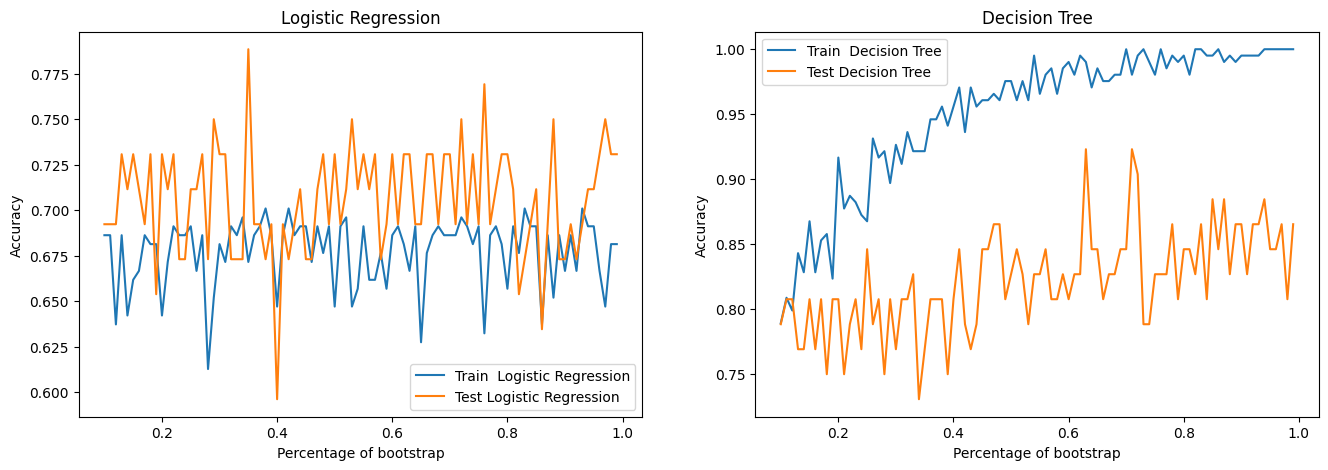

In [34]:
fig, axs = plt.subplots(1, len(mdls_bag), figsize=(16,5))

for i, (mdl_name, mdl) in enumerate(mdls_bag):
    axs[i].plot(BAG_PERC_lst, mdls_bag_perf[mdl_name]['train' ], label='Train  ' + mdl_name)
    axs[i].plot(BAG_PERC_lst, mdls_bag_perf[mdl_name]['test']  , label='Test '   + mdl_name)

    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Percentage of bootstrap')
    axs[i].set_title(mdl_name)
    axs[i].legend()


# plt.ylabel('Accuracy')
# plt.xlabel('Number of estimators')
# plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why is the accuracy curve not smooth?
1. Why does increasing the size of the bootstrap sample improve accuracy in the case of decision trees?
1. Why does it not improve accuracy in the case of logistic regression?

**Answers**

1. The accuracy curve is not smooth because the sampling process in bagging is random. Each bootstrap sample is generated by random selection (with replacement), so even for similar sample sizes, the subsets of data differ. This random variation causes small fluctuations in model performance from one sample size to another, leading to a non-smooth accuracy curve.
   
1. Decision trees are high-variance models, meaning they perform better when trained on larger, more diverse data subsets. Increasing the bootstrap size provides more comprehensive samples, which helps reduce variance by capturing a broader picture of the data. This diversity allows each tree in the ensemble to generalize better, thereby improving overall accuracy as it balances bias and variance more effectively.

   
1. Logistic regression is a low-variance, high-bias model. Its performance depends mainly on the linear relationships in the data rather than the particular samples used for training. Therefore, increasing bootstrap size does not significantly affect its performance. Bagging generally has a limited impact on low-variance models like logistic regression, as it does not benefit from additional sample diversity the way high-variance models, like decision trees, do.

In [36]:
print('Trees and forests are crucial for life on earth')
print('Not these trees though :) ... prune them, optimize them, or burn their overfitting branches!')

Trees and forests are crucial for life on earth
Not these trees though :) ... prune them, optimize them, or burn their overfitting branches!
